In [12]:
import pandas as pd
import numpy as np

RANDOM_STATE = 404

In [13]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [14]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [15]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)
df.shape

(944, 37)

### Generating missing data based on sklearn imputers

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import warnings
# warnings.filterwarnings('ignore')

imputer_df = df.copy()

missing_flag_cols = [col for col in df.columns if col.endswith('_MISSING')]

# imp = SimpleImputer(missing_values=-1, strategy='median')
imp = IterativeImputer(missing_values=-1, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate over columns with missingness flags to heck if imputation is needed and apply imputation only if missingness flag is set to 1
for missing_flag_col in missing_flag_cols:
    value_col = missing_flag_col.replace('_MISSING', '')
    
    if (imputer_df[missing_flag_col] == 1).any():
        imp.fit(imputer_df[[value_col]])
        imputer_df[value_col] = imp.transform(imputer_df[[value_col]]).ravel()
        # # Update missingness flag to 2 for imputed values
        # imputer_df[missing_flag_col] = imputer_df[missing_flag_col].replace(1, 2)

imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]
imputer_df.to_csv('data/HAD_no_missingness.csv', index=False)
imputer_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0,1,1,0,1,...,1,0,0,0,0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0,1,0,1,0,...,0,0,0,1,0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,98.0,110.0,120.0,217.0


### Using BIC to get the optimal number of components for GMM

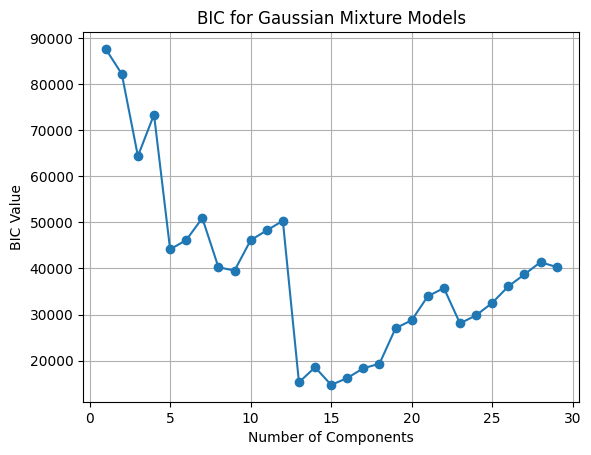

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    bic = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    return bic

n_components_range = range(1, 30)

bic_values = compute_bic(imputer_df, n_components_range)

optimal_n_components = n_components_range[np.argmin(bic_values)]

plt.plot(n_components_range, bic_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.title('BIC for Gaussian Mixture Models')
plt.grid(True)
plt.show()

### Gaussian Mixture Model fitting

In [18]:
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)
gmm.fit(imputer_df)

GaussianMixture(n_components=15, random_state=404)

### Imputing missing values with the help of conditional GMM

In [19]:
temp_df = df.copy()
temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]

In [20]:
imputer_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0,1,1,0,1,...,1,0,0,0,0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0,1,0,1,0,...,0,0,0,1,0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,98.0,110.0,120.0,217.0


In [21]:
pos = 0
imputer_df[imputer_df.columns[pos]]

0      70.0
1      55.0
2      73.0
3      81.0
4      81.0
       ... 
939    71.0
940    63.0
941    61.0
942    80.0
943    90.0
Name: AGE, Length: 944, dtype: float64

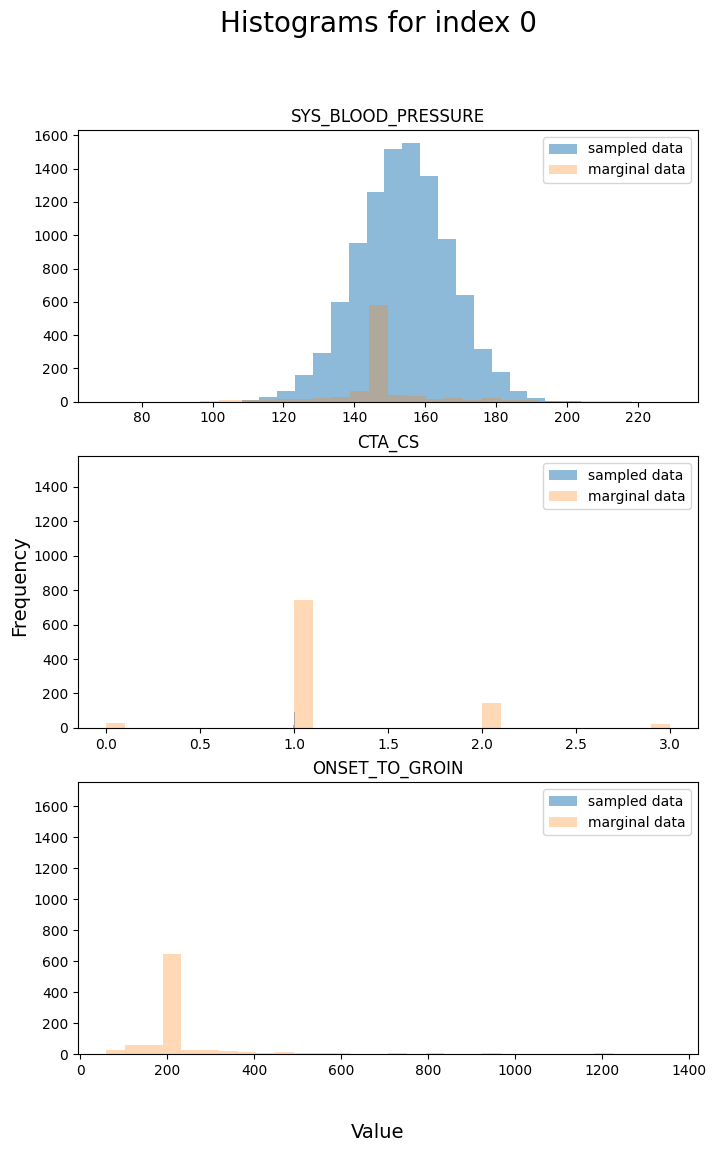

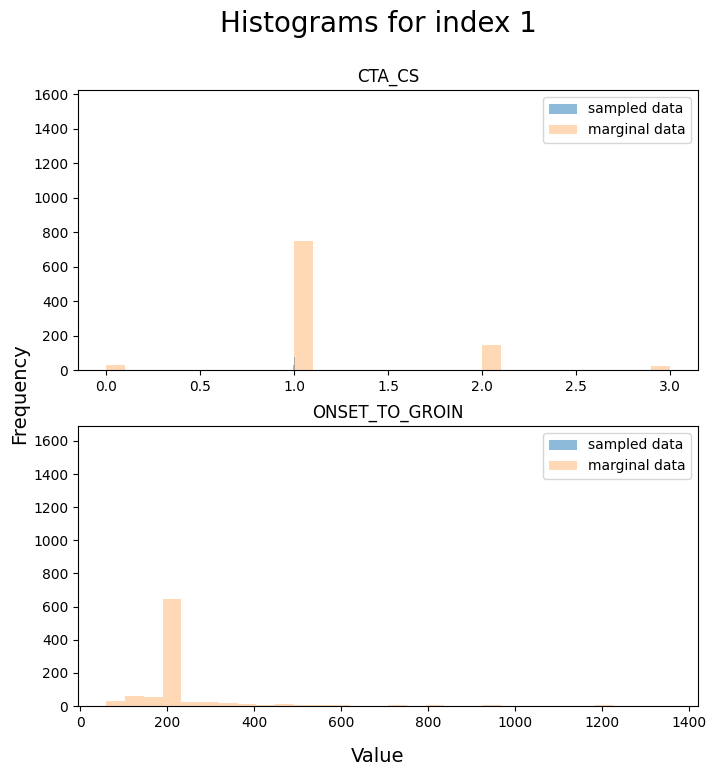

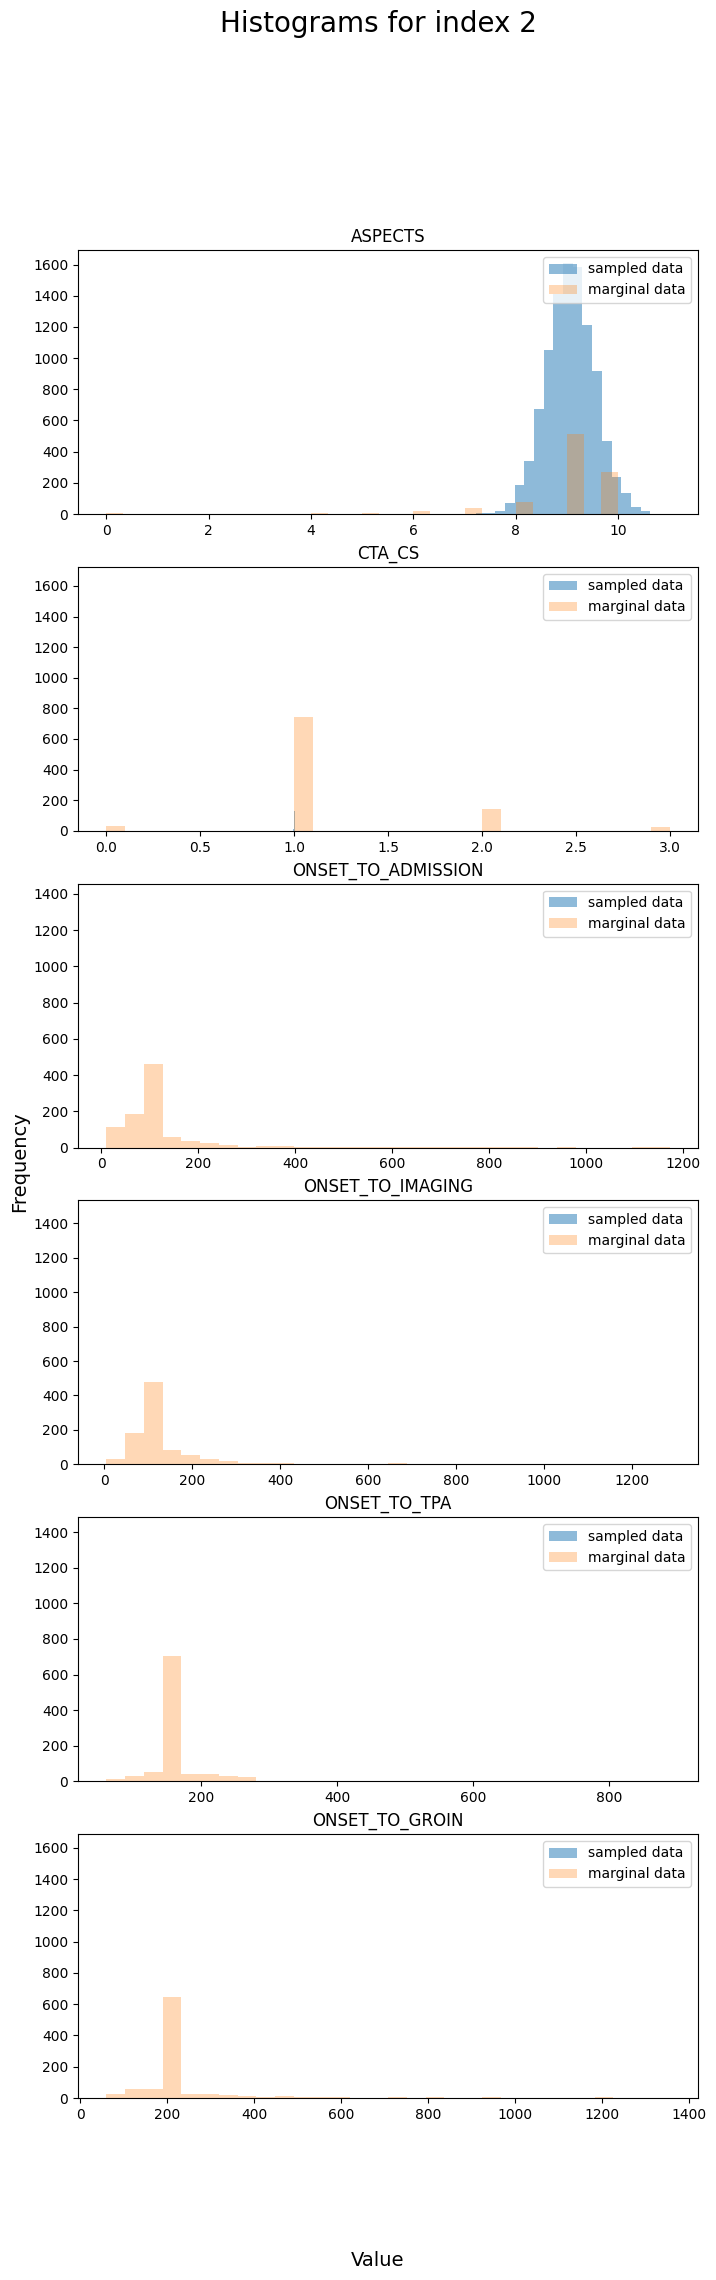

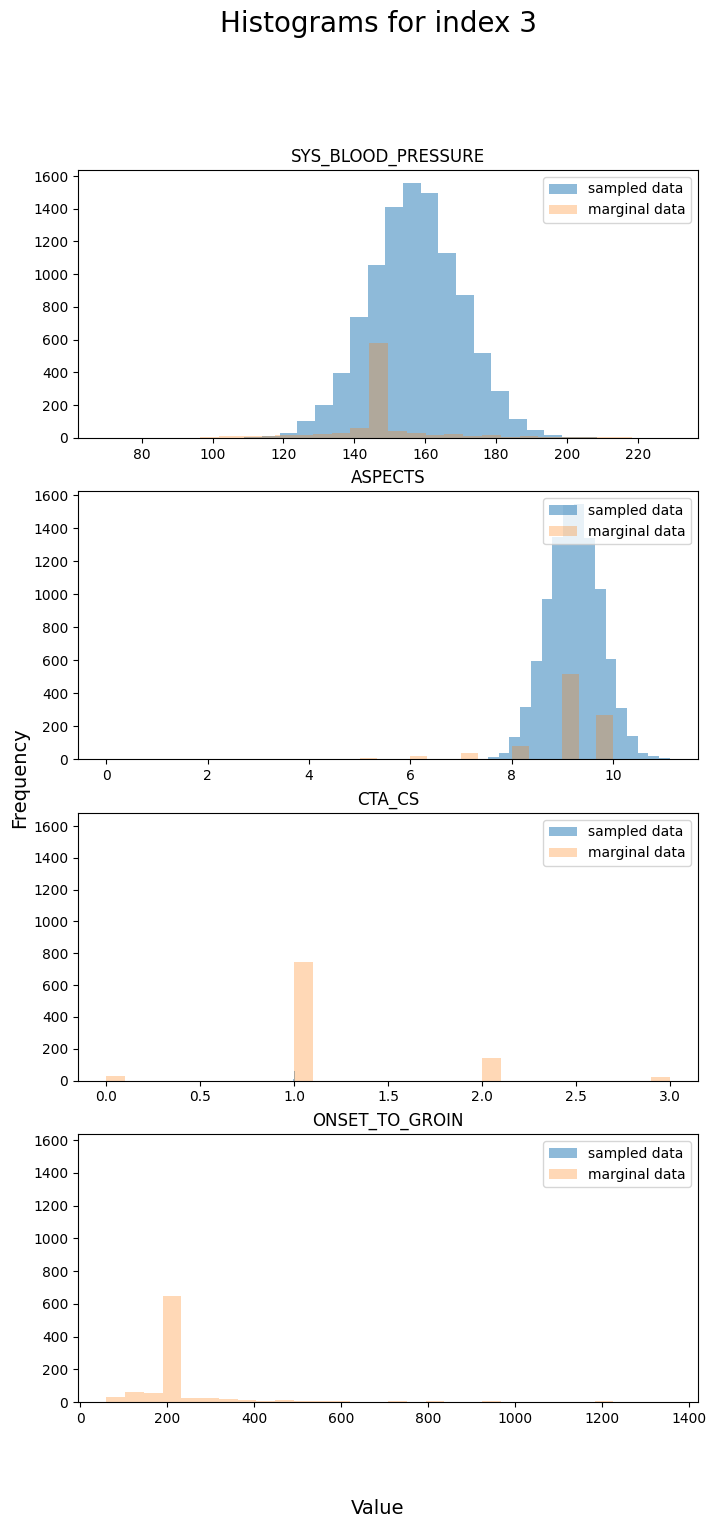

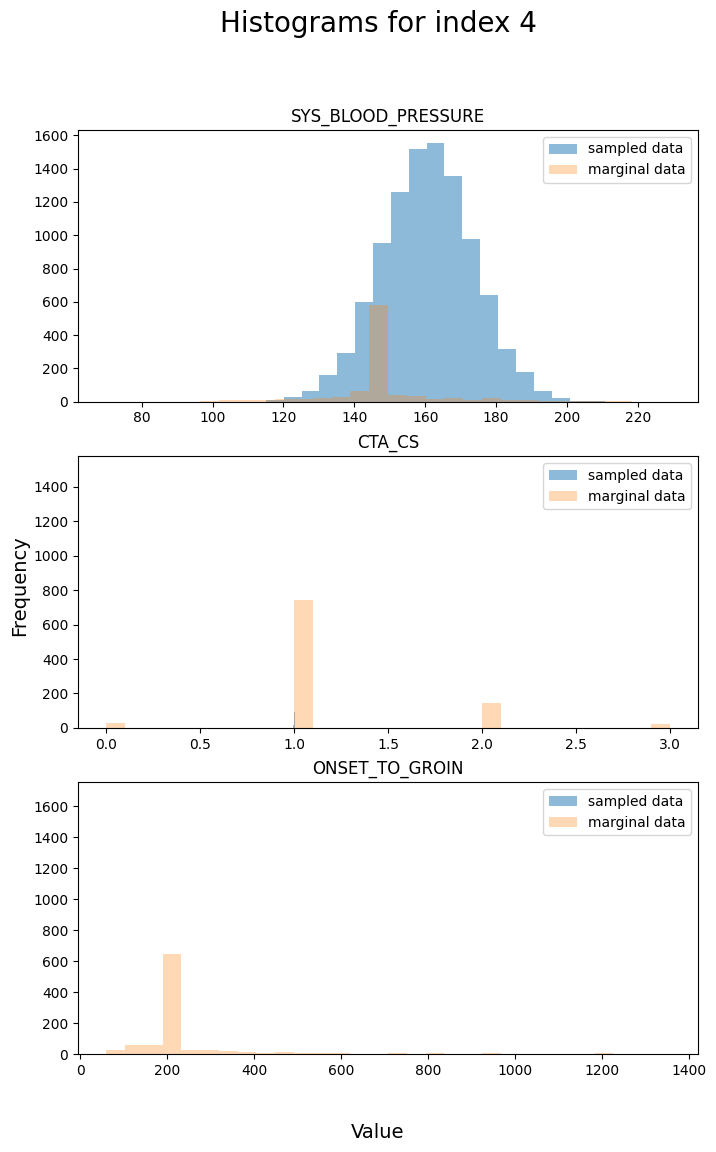

In [25]:
from ConditionalGMM.ConditionalGMM.condGMM import CondGMM

unknown_features_indexes = []

for index, row in df.head(5).iterrows():
    for missing_flag_col in missing_flag_cols:
        mv_column = missing_flag_col
        v_column = missing_flag_col.replace('_MISSING', '')
        mv_flag = row[mv_column]
        v_value = row[v_column]
        
        if mv_flag == 1 and v_value == -1:
            unknown_features_indexes.append(temp_df.columns.get_loc(v_column))
            
    if not unknown_features_indexes:
        continue
        
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    known_features_values = temp_df.iloc[index, known_features_indexes]

    cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)

    sampled_data = cGMM.rvs(known_features_values, size=10000, random_state=RANDOM_STATE)

    average_values = np.mean(sampled_data, axis=0)

    temp_df.iloc[index, unknown_features_indexes] = average_values.astype(int)

    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    if sampled_data.shape[1] == 1:
        axs.hist(sampled_data, bins=30, alpha=0.5)
        axs.set_title(f'{temp_df.columns[unknown_features_indexes[0]]}')
    else:
        for i in range(sampled_data.shape[1]):
            axs[i].hist(sampled_data[:, i], bins=20, alpha=0.5, label='sampled data')
            axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=30, alpha=0.3, label='marginal data')
            axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
            axs[i].legend(loc='upper right')

    fig.suptitle(f'Histograms for index {index}', fontsize=20)
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

    plt.show()

    unknown_features_indexes = []
    known_features_indexes = []